**Chapter 04 – Introduction to Artificial Neural Networks with Keras**

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

COLOR = 'white'

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.__version__

'2.0.0'

In [4]:
keras.__version__

'2.2.4-tf'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [6]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [7]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [8]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

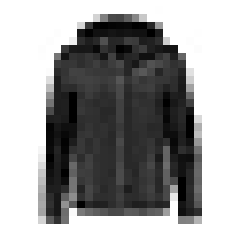

In [9]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [10]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [11]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [12]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [13]:
X_valid.shape

(5000, 28, 28)

In [14]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


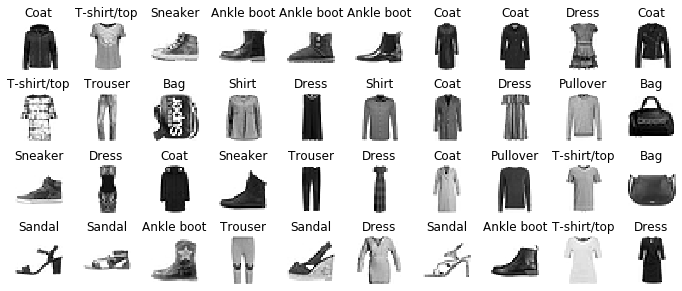

In [15]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

## Creating the Model Using the Sequential API

Now let’s build the neural network! Here is a classification MLP with two hidden layers

In [16]:
model = keras.models.Sequential() # creates a Sequential model
model.add(keras.layers.Flatten(input_shape=[28, 28])) # Flatten layer convert each input image into a 1D array
model.add(keras.layers.Dense(300, activation="relu")) # Dense hidden layer with 300 neurons use the ReLU activation function
model.add(keras.layers.Dense(100, activation="relu")) # Dense hidden layer with 100 neurons use the ReLU activation function
model.add(keras.layers.Dense(10, activation="softmax")) # Dense output layer with 10 neurons (one per class) using the softmax activation function

In [17]:
# clear session
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Instead of adding the layers one by one as we just did, you can pass a list of layers when creating the Sequential model

In [18]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

### Activation function

 <img src="resources/chapter_4/activation_function.png">

In [19]:
model.layers

***summary()*** method displays all the model’s layers

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


You can easily get a model’s list of layers, to fetch a layer by its index, or you can fetch it by name

In [21]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [22]:
model.get_layer(hidden1.name) is hidden1

True

All the parameters of a layer can be accessed using its get_weights() and set_weights() method.

In [23]:
weights, biases = hidden1.get_weights()

In [24]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [25]:
weights.shape

(784, 300)

In [26]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [27]:
biases.shape

(300,)

## Compiling the Model

Call compile() method to specify the loss function and the optimizer to use.

In [28]:
model.compile(loss="sparse_categorical_crossentropy", # how to know model is good
              optimizer="sgd", # how weight learning, or use 'adam'
              metrics=["accuracy"]) # show log

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

- We use the "sparse_categorical_crossen tropy" loss because we have sparse labels (i.e., for each instance there is just a target class index, from 0 to 9 in this case)
- The optimizer, "sgd" simply means that we will train the model using simple Stochastic Gradient Descent.
- Since this is a classifier, it’s useful to measure its "accuracy" during training and evaluation.

## Training and Evaluating the Model


In [29]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 8s 146us/sample - loss: 0.7228 - accuracy: 0.7622 - val_loss: 0.5313 - val_accuracy: 0.8140
Epoch 2/30
55000/55000 [==============================] - 7s 120us/sample - loss: 0.4839 - accuracy: 0.8321 - val_loss: 0.4496 - val_accuracy: 0.8452
Epoch 3/30
55000/55000 [==============================] - 6s 115us/sample - loss: 0.4380 - accuracy: 0.8468 - val_loss: 0.4170 - val_accuracy: 0.8558
Epoch 4/30
55000/55000 [==============================] - 6s 115us/sample - loss: 0.4128 - accuracy: 0.8558 - val_loss: 0.3899 - val_accuracy: 0.8656
Epoch 5/30
55000/55000 [==============================] - 6s 114us/sample - loss: 0.3930 - accuracy: 0.8623 - val_loss: 0.3976 - val_accuracy: 0.8608
Epoch 6/30
55000/55000 [==============================] - 6s 115us/sample - loss: 0.3777 - accuracy: 0.8669 - val_loss: 0.3725 - val_accuracy: 0.8740
Epoch 7/30
55000/55000 [===========================

In [30]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [31]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


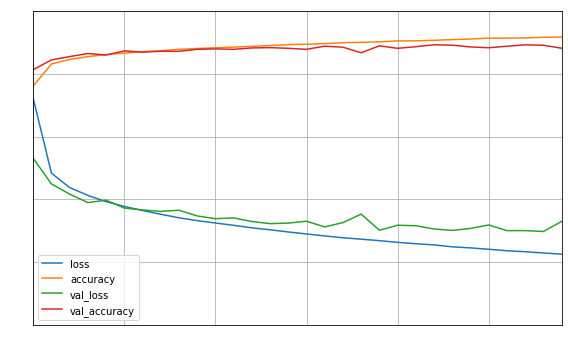

In [33]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [34]:
# evaluate model
model.evaluate(X_test, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.36675315907001493, 0.8667]

## Using the Model to Make Predictions

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

In [44]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

In [45]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [46]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


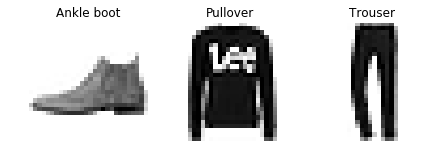

In [47]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [45]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [48]:
np.random.seed(42)
tf.random.set_seed(42)

Building, training, evaluating and using a regression MLP using the Sequential API to make predictions is quite similar to what we did for classification. The main differences are the output layer has a single neuron (since we only want to predict a single value) and uses no activation function, and the loss function is the mean squared error.

In [49]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 139us/step - loss: 2.7716 - val_loss: 1.9575 ETA: 0s - loss: 3.03
Epoch 2/20
11610/11610 [==============================] - 1s 78us/step - loss: 0.8522 - val_loss: 1.5750
Epoch 3/20
11610/11610 [==============================] - 1s 70us/step - loss: 0.7215 - val_loss: 0.7526
Epoch 4/20
11610/11610 [==============================] - 1s 76us/step - loss: 0.6766 - val_loss: 0.9910
Epoch 5/20
11610/11610 [==============================] - 1s 74us/step - loss: 0.6528 - val_loss: 0.6104
Epoch 6/20
11610/11610 [==============================] - 1s 66us/step - loss: 0.6210 - val_loss: 0.5902
Epoch 7/20
11610/11610 [==============================] - 1s 68us/step - loss: 0.5932 - val_loss: 0.7170
Epoch 8/20
11610/11610 [==============================] - 1s 76us/step - loss: 0.5775 - val_loss: 0.5460
Epoch 9/20
11610/11610 [==============================] - 1s 85us/step - loss: 0.5581 - v

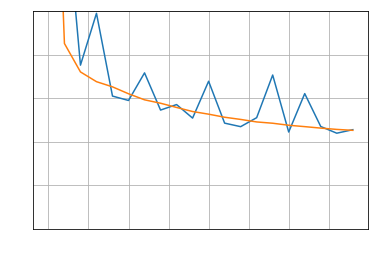

In [53]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [51]:
y_pred

array([[0.7977917],
       [1.6714668],
       [3.2302828]], dtype=float32)

# Building Complex Models Using the Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. 

For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

 <img src="resources/chapter_4/wide_deep_neural_network.png">

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

In [54]:
input_ = keras.layers.Input(shape=X_train.shape[1:]) # create an Input object
hidden1 = keras.layers.Dense(30, activation="relu")(input_) # create a Dense layer with 30 neurons and using the ReLU activation function
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1) # create a second hidden layer, and again we use it as a function
concat = keras.layers.concatenate([input_, hidden2]) # create a Concatenate() layer to concatenate the input and the output of the second hidden layer
output = keras.layers.Dense(1)(concat) # create the output layer, with a single neuron and no activation function

model = keras.models.Model(inputs=[input_], outputs=[output]) # create a Keras Model, specifying which inputs and outputs to use.

In [55]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 30)           270         input_3[0][0]                    
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 30)           930         dense_25[0][0]                   
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 38)           0           input_3[0][0]                    
                                                                 dense_26[0][0]             

In [56]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 0s 43us/sample - loss: 1.2544 - val_loss: 2.9415
Epoch 2/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.6531 - val_loss: 0.8754
Epoch 3/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5873 - val_loss: 0.5529
Epoch 4/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5574 - val_loss: 0.5205
Epoch 5/20
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5343 - val_loss: 0.5399
Epoch 6/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5160 - val_loss: 0.4793
Epoch 7/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5004 - val_loss: 0.4655
Epoch 8/20
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4873 - val_loss: 0.4820
Epoch 9/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4761 - val_l

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

 <img src="resources/chapter_4/handling_multiple_inputs.png">

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

In [58]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [59]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 45us/sample - loss: 1.8070 - val_loss: 0.8422
Epoch 2/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.6752 - val_loss: 0.6426
Epoch 3/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5969 - val_loss: 0.5829
Epoch 4/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5580 - val_loss: 0.5259
Epoch 5/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5317 - val_loss: 0.5005
Epoch 6/20
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5125 - val_loss: 0.4792
Epoch 7/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4963 - val_loss: 0.4786
Epoch 8/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4840 - val_loss: 0.4562
Epoch 9/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4733 - val_l

Adding an auxiliary output for regularization:

 <img src="resources/chapter_4/handling_multiple_outputs.png">

In [60]:
np.random.seed(42)
tf.random.set_seed(42)

In [61]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [62]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [63]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train_2], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 57us/sample - loss: 2.1325 - main_output_loss: 1.9139 - aux_output_loss: 4.0950 - val_loss: 1.6650 - val_main_output_loss: 0.8892 - val_aux_output_loss: 8.6440
Epoch 2/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.8870 - main_output_loss: 0.6930 - aux_output_loss: 2.6303 - val_loss: 1.4991 - val_main_output_loss: 0.6627 - val_aux_output_loss: 9.0235
Epoch 3/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.7421 - main_output_loss: 0.6079 - aux_output_loss: 1.9515 - val_loss: 1.4340 - val_main_output_loss: 0.5748 - val_aux_output_loss: 9.1628
Epoch 4/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.6766 - main_output_loss: 0.5683 - aux_output_loss: 1.6515 - val_loss: 1.3260 - val_main_output_loss: 0.5579 - val_aux_output_loss: 8.2343
Epoch 5/20
11610/11610 [==============================] - 0s 38us/s

In [64]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])

y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

5160/5160 [==============================] - 0s 26us/sample - loss: 0.4661 - main_output_loss: 0.4167 - aux_output_loss: 0.9138


There are also many use cases in which you may want to have multiple outputs:
- The task may demand it, for example you may want to locate and classify the main object in a picture.
- You may have multiple independent tasks to perform based on the same data.

# Saving and Restoring

In [68]:
np.random.seed(42)
tf.random.set_seed(42)

In [69]:
# let's create a small neural network
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [70]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 0s 41us/sample - loss: 1.8807 - val_loss: 0.7701
Epoch 2/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.6570 - val_loss: 0.7268
Epoch 3/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5932 - val_loss: 0.6569
Epoch 4/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5547 - val_loss: 0.5244
Epoch 5/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5269 - val_loss: 0.5068
Epoch 6/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5035 - val_loss: 0.5028
Epoch 7/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4852 - val_loss: 0.4924
Epoch 8/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4709 - val_loss: 0.4534
Epoch 9/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4578 - val_l

In [71]:
model.save("my_keras_model.h5")

In [72]:
model = keras.models.load_model("my_keras_model.h5")

In [73]:
model.predict(X_new)

array([[0.5492519],
       [1.674789 ],
       [3.0483952]], dtype=float32)

In [74]:
model.save_weights("my_keras_weights.ckpt")

In [75]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

The fit() method accepts a callbacks argument that lets you specify a list of objects that Keras will call during training at the start and end of training, at the start and end of each epoch and even before and after processing each batch.

In [76]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [77]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [78]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

# create a model checkpoint callback, save best model
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 49us/sample - loss: 1.8807 - val_loss: 0.7701
Epoch 2/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.6570 - val_loss: 0.7268
Epoch 3/10
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5932 - val_loss: 0.6569
Epoch 4/10
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5547 - val_loss: 0.5244
Epoch 5/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5269 - val_loss: 0.5068
Epoch 6/10
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5035 - val_loss: 0.5028
Epoch 7/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4852 - val_loss: 0.4924
Epoch 8/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4709 - val_loss: 0.4534
Epoch 9/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4578 - val_l

In [79]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

# create a early stopping callback, stop the training if loss not reduce
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 43us/sample - loss: 0.4483 - val_loss: 0.4280
Epoch 2/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4393 - val_loss: 0.4106
Epoch 3/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4319 - val_loss: 0.4078
Epoch 4/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4262 - val_loss: 0.4037
Epoch 5/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4205 - val_loss: 0.3956
Epoch 6/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4160 - val_loss: 0.3894
Epoch 7/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.4116 - val_loss: 0.3891
Epoch 8/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4077 - val_loss: 0.3817
Epoch 9/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.404

In [80]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [81]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
10144/11610 [=========================>....] - ETA: 0s - loss: 0.3427
val/train: 0.98
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3467 - val_loss: 0.3384
